# Use TTH_Template Custom Notebook template

In [120]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
import seaborn as sns

from collections import OrderedDict

from scipy.optimize import curve_fit

from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

from fosforml.model_manager.snowflakesession import get_session
from fosforml import register_model

# Read data from Snowflake

In [121]:
my_session = get_session()

In [122]:
table_name = 'AIRLINES'

sf_df = my_session.sql("select * from {}".format(table_name))
airlines_names = sf_df.to_pandas()

In [123]:
table_name = 'FLIGHTS'

sf_df = my_session.sql("select * from {}".format(table_name))
df = sf_df.to_pandas()

In [124]:
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (5819079, 31)


In [125]:
min(df['SCHEDULED_ARRIVAL']), max(df['SCHEDULED_ARRIVAL'])

(1, 2400)

In [126]:
min(df['SCHEDULED_DEPARTURE']), max(df['SCHEDULED_DEPARTURE'])

(1, 2359)

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   YEAR                      int16  
 1   MONTH                     int8   
 2   DAY                       int8   
 3   DAY_OF_WEEK               int8   
 4   AIRLINE__CODE             object 
 5   FLIGHT_NUMBER             int16  
 6   TAIL_NUMBER               object 
 7   ORIGIN_AIRPORT_CODE       object 
 8   DESTINATION_AIRPORT_CODE  object 
 9   SCHEDULED_DEPARTURE       int16  
 10  DEPARTURE_TIME            float64
 11  DEPARTURE_DELAY           float64
 12  TAXI_OUT                  float64
 13  WHEELS_OFF                float64
 14  SCHEDULED_TIME            float64
 15  ELAPSED_TIME              float64
 16  AIR_TIME                  float64
 17  DISTANCE                  int16  
 18  WHEELS_ON                 float64
 19  TAXI_IN                   float64
 20  SCHEDULED_ARRIVAL       

In [128]:
pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'})

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE__CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640


In [129]:
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info = pd.concat([tab_info,pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'})], ignore_index=True)
tab_info = pd.concat([tab_info,pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'})],ignore_index=True)
tab_info

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE__CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,int16,int8,int8,int8,object,int16,object,object,object,int16,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,int16,float64,float64,int8,int8,object,float64,float64,float64,float64,float64
1,0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640
2,0.0,0.0,0.0,0.0,0.0,0.0,0.252978,0.0,0.0,0.0,1.480526,1.480526,1.530259,1.530259,0.000103,1.805629,1.805629,0.0,1.589822,1.589822,0.0,1.589822,1.805629,0.0,0.0,98.455357,81.72496,81.72496,81.72496,81.72496,81.72496


In [130]:
#table_name = 'FLIGHTS_FULL'
table_name = 'AIRPORTS'

sf_df = my_session.sql("select * from {}".format(table_name))
airports = sf_df.to_pandas()

In [131]:
airports.shape

(322, 7)

In [132]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [133]:
count_flights = df['ORIGIN_AIRPORT_CODE'].value_counts()

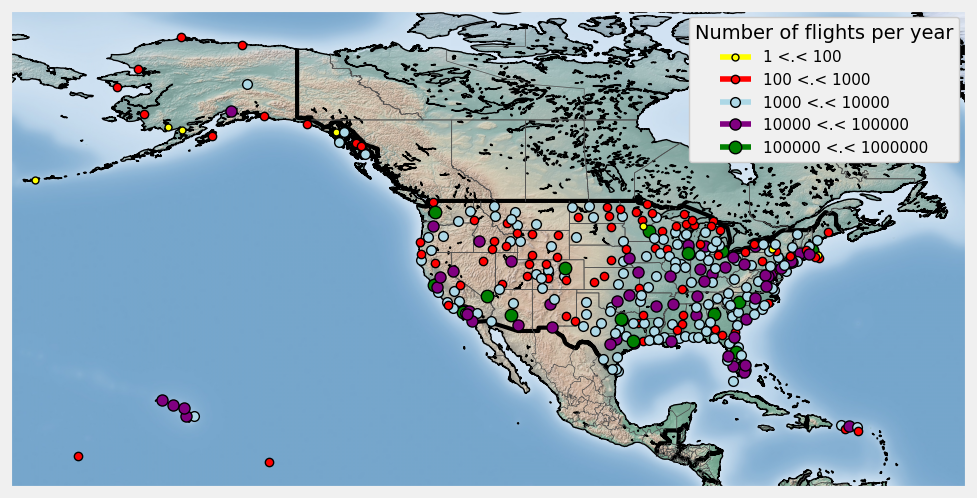

In [134]:
#___________________________
plt.figure(figsize=(11,11))
#________________________________________
# define properties of markers and labels
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
#____________________________________________________________
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')
#_____________________
# put airports on map
for index, (code, y,x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind],
             markeredgecolor='k', label = labels[ind])
#_____________________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Number of flights per year', frameon = True, framealpha = 1)
plt.show()

# Given the large size of the dataset, I decide to consider only a subset of the data in order to reduce the computational time

In [135]:
df = df[df['MONTH'] == 1]

In [136]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

# The SCHEDULED_DEPARTURE variable, the hour of the take-off is coded as a float where the two first digits indicate the hour and the two last, the minutes. This format is not convenient and I thus convert it. Finally, I merge the take-off hour with the flight date. To proceed with these transformations

In [137]:
#_________________________________________________________
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if (chaine == 2400 or chaine == '2400') : chaine = '0000'
        #chaine = "{0:04d}".format(int(chaine))
        #print (chaine)
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows(): 
        print ("1 -> ", cols['DATE'], "----",cols['SCHEDULED_DEPARTURE'])
        if pd.isnull(cols['SCHEDULED_DEPARTURE']):
            print ("2 -> Null")
            liste.append(np.nan)
        elif (float(cols['SCHEDULED_DEPARTURE']) == 2400 or float(cols['SCHEDULED_DEPARTURE']) == '2400'):
            cols['DATE'] += datetime.timedelta(days=1)
            cols['SCHEDULED_DEPARTURE'] = datetime.time(0,0)
            print ("3 -> ", cols['DATE'], "----",cols['SCHEDULED_DEPARTURE'])
            liste.append(combine_date_heure(cols))
        else:
            cols['SCHEDULED_DEPARTURE'] = format_heure(cols['SCHEDULED_DEPARTURE'])
            print ("4 -> ", cols['DATE'], cols['SCHEDULED_DEPARTURE'])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [138]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)

In [139]:
df = df[['DATE','AIRLINE__CODE', 'ORIGIN_AIRPORT_CODE', 'DESTINATION_AIRPORT_CODE',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]

In [140]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 469968 entries, 4472832 to 4942799
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DATE                      469968 non-null  object        
 1   AIRLINE__CODE             469968 non-null  object        
 2   ORIGIN_AIRPORT_CODE       469968 non-null  object        
 3   DESTINATION_AIRPORT_CODE  469968 non-null  object        
 4   SCHEDULED_DEPARTURE       469968 non-null  object        
 5   DEPARTURE_TIME            458311 non-null  float64       
 6   DEPARTURE_DELAY           458311 non-null  float64       
 7   SCHEDULED_ARRIVAL         469968 non-null  int16         
 8   ARRIVAL_TIME              457697 non-null  float64       
 9   ARRIVAL_DELAY             457013 non-null  float64       
 10  SCHEDULED_TIME            469968 non-null  float64       
 11  ELAPSED_TIME              457013 non-null  float64       
 12  

In [141]:
df_temp.head()

,DATE,AIRLINE__CODE,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,TEMP
4472832,2015-01-01,AS,ANC,SEA,00:05:00,2354.0,-11.0,430,408.0,-22.0,205.0,194.0,2015-01-01 00:05:00
4472833,2015-01-01,AA,LAX,PBI,00:10:00,2.0,-8.0,750,741.0,-9.0,280.0,279.0,2015-01-01 00:10:00
4472834,2015-01-01,US,SFO,CLT,00:20:00,18.0,-2.0,806,811.0,5.0,286.0,293.0,2015-01-01 00:20:00
4472835,2015-01-01,AA,LAX,MIA,00:20:00,15.0,-5.0,805,756.0,-9.0,285.0,281.0,2015-01-01 00:20:00
4472836,2015-01-01,AS,SEA,ANC,00:25:00,24.0,-1.0,320,259.0,-21.0,235.0,215.0,2015-01-01 00:25:00


In [142]:
df_temp = df.copy()
df_temp['SCHEDULED_DEPARTURE'] = df_temp['SCHEDULED_DEPARTURE'].astype(str).str.zfill(4)
df_temp['SCHEDULED_DEPARTURE'] = df_temp['SCHEDULED_DEPARTURE'].apply(format_heure)
df_temp['DATE'] = df_temp['DATE'].astype(str)
df_temp['SCHEDULED_DEPARTURE'] = df_temp['SCHEDULED_DEPARTURE'].astype(str)
df_temp['TEMP'] = pd.to_datetime(df_temp['DATE']+ ' ' + df_temp['SCHEDULED_DEPARTURE'])
#create_flight_time(df_temp, 'SCHEDULED_DEPARTURE')

In [143]:
df_temp.isnull().sum()

DATE                            0
AIRLINE__CODE                   0
ORIGIN_AIRPORT_CODE             0
DESTINATION_AIRPORT_CODE        0
SCHEDULED_DEPARTURE             0
DEPARTURE_TIME              11657
DEPARTURE_DELAY             11657
SCHEDULED_ARRIVAL               0
ARRIVAL_TIME                12271
ARRIVAL_DELAY               12955
SCHEDULED_TIME                  0
ELAPSED_TIME                12955
TEMP                            0
dtype: int64

In [144]:
df.isnull().sum()

DATE                            0
AIRLINE__CODE                   0
ORIGIN_AIRPORT_CODE             0
DESTINATION_AIRPORT_CODE        0
SCHEDULED_DEPARTURE             0
DEPARTURE_TIME              11657
DEPARTURE_DELAY             11657
SCHEDULED_ARRIVAL               0
ARRIVAL_TIME                12271
ARRIVAL_DELAY               12955
SCHEDULED_TIME                  0
ELAPSED_TIME                12955
dtype: int64

In [145]:
df.shape

(469968, 12)

In [146]:
df.dropna(inplace=True)

In [147]:
df.shape

(457013, 12)

In [148]:
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].astype(str).str.zfill(4)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].astype(str).str.zfill(4)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].astype(int).astype(str).str.zfill(4)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].astype(int).astype(str).str.zfill(4)

In [149]:
df.head()

,DATE,AIRLINE__CODE,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
4472832,2015-01-01,AS,ANC,SEA,0005,2354,-11.0,0430,0408,-22.0,205.0,194.0
4472833,2015-01-01,AA,LAX,PBI,0010,0002,-8.0,0750,0741,-9.0,280.0,279.0
4472834,2015-01-01,US,SFO,CLT,0020,0018,-2.0,0806,0811,5.0,286.0,293.0
4472835,2015-01-01,AA,LAX,MIA,0020,0015,-5.0,0805,0756,-9.0,285.0,281.0
4472836,2015-01-01,AS,SEA,ANC,0025,0024,-1.0,0320,0259,-21.0,235.0,215.0


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 457013 entries, 4472832 to 4942799
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DATE                      457013 non-null  datetime64[ns]
 1   AIRLINE__CODE             457013 non-null  object        
 2   ORIGIN_AIRPORT_CODE       457013 non-null  object        
 3   DESTINATION_AIRPORT_CODE  457013 non-null  object        
 4   SCHEDULED_DEPARTURE       457013 non-null  object        
 5   DEPARTURE_TIME            457013 non-null  object        
 6   DEPARTURE_DELAY           457013 non-null  float64       
 7   SCHEDULED_ARRIVAL         457013 non-null  object        
 8   ARRIVAL_TIME              457013 non-null  object        
 9   ARRIVAL_DELAY             457013 non-null  float64       
 10  SCHEDULED_TIME            457013 non-null  float64       
 11  ELAPSED_TIME              457013 non-null  float64       
dtype

In [151]:
#df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')

In [152]:
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].apply(format_heure)
df['DATE'] = df['DATE'].astype(str)
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].astype(str)
df['SCHEDULED_DEPARTURE'] = pd.to_datetime(df['DATE']+ ' ' + df['SCHEDULED_DEPARTURE'])

In [153]:
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)

In [154]:
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)

In [155]:
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)

In [156]:
df.head()

,DATE,AIRLINE__CODE,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
4472832,2015-01-01,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
4472833,2015-01-01,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
4472834,2015-01-01,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
4472835,2015-01-01,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4472836,2015-01-01,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0


In [157]:
variables_to_remove = ['DATE']
df.drop(variables_to_remove, axis = 1, inplace = True)

In [158]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,AIRLINE__CODE,0,100.0
1,ORIGIN_AIRPORT_CODE,0,100.0
2,DESTINATION_AIRPORT_CODE,0,100.0
3,SCHEDULED_DEPARTURE,0,100.0
4,DEPARTURE_TIME,0,100.0
5,DEPARTURE_DELAY,0,100.0
6,SCHEDULED_ARRIVAL,0,100.0
7,ARRIVAL_TIME,0,100.0
8,ARRIVAL_DELAY,0,100.0
9,SCHEDULED_TIME,0,100.0


In [159]:
df.dropna(inplace = True)

In [160]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [161]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [162]:
abbr_companies

{'UA': 'United Air Lines Inc.',
 'AA': 'American Airlines Inc.',
 'US': 'US Airways Inc.',
 'F9': 'Frontier Airlines Inc.',
 'B6': 'JetBlue Airways',
 'OO': 'Skywest Airlines Inc.',
 'AS': 'Alaska Airlines Inc.',
 'NK': 'Spirit Air Lines',
 'WN': 'Southwest Airlines Co.',
 'DL': 'Delta Air Lines Inc.',
 'EV': 'Atlantic Southeast Airlines',
 'HA': 'Hawaiian Airlines Inc.',
 'MQ': 'American Eagle Airlines Inc.',
 'VX': 'Virgin America'}

# Basic Statistics

In [163]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________

In [164]:
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE__CODE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE__CODE,,,,
VX,-20.0,397.0,4647.0,6.896277
HA,-26.0,1003.0,6408.0,1.311954
F9,-32.0,696.0,6735.0,17.910765
NK,-28.0,557.0,8632.0,13.073100
AS,-47.0,444.0,13151.0,3.072086
B6,-27.0,500.0,20482.0,9.988331
MQ,-29.0,780.0,27568.0,15.995865
US,-26.0,638.0,32478.0,5.175011
UA,-40.0,886.0,37363.0,13.885555


In [166]:
df.columns

Index(['AIRLINE__CODE', 'ORIGIN_AIRPORT_CODE', 'DESTINATION_AIRPORT_CODE',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'SCHEDULED_TIME',
       'ELAPSED_TIME'],
      dtype='object')

In [171]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 457013 entries, 4472832 to 4942799
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   AIRLINE__CODE    457013 non-null  object 
 1   DEPARTURE_DELAY  457013 non-null  float64
dtypes: float64(1), object(1)
memory usage: 10.5+ MB


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

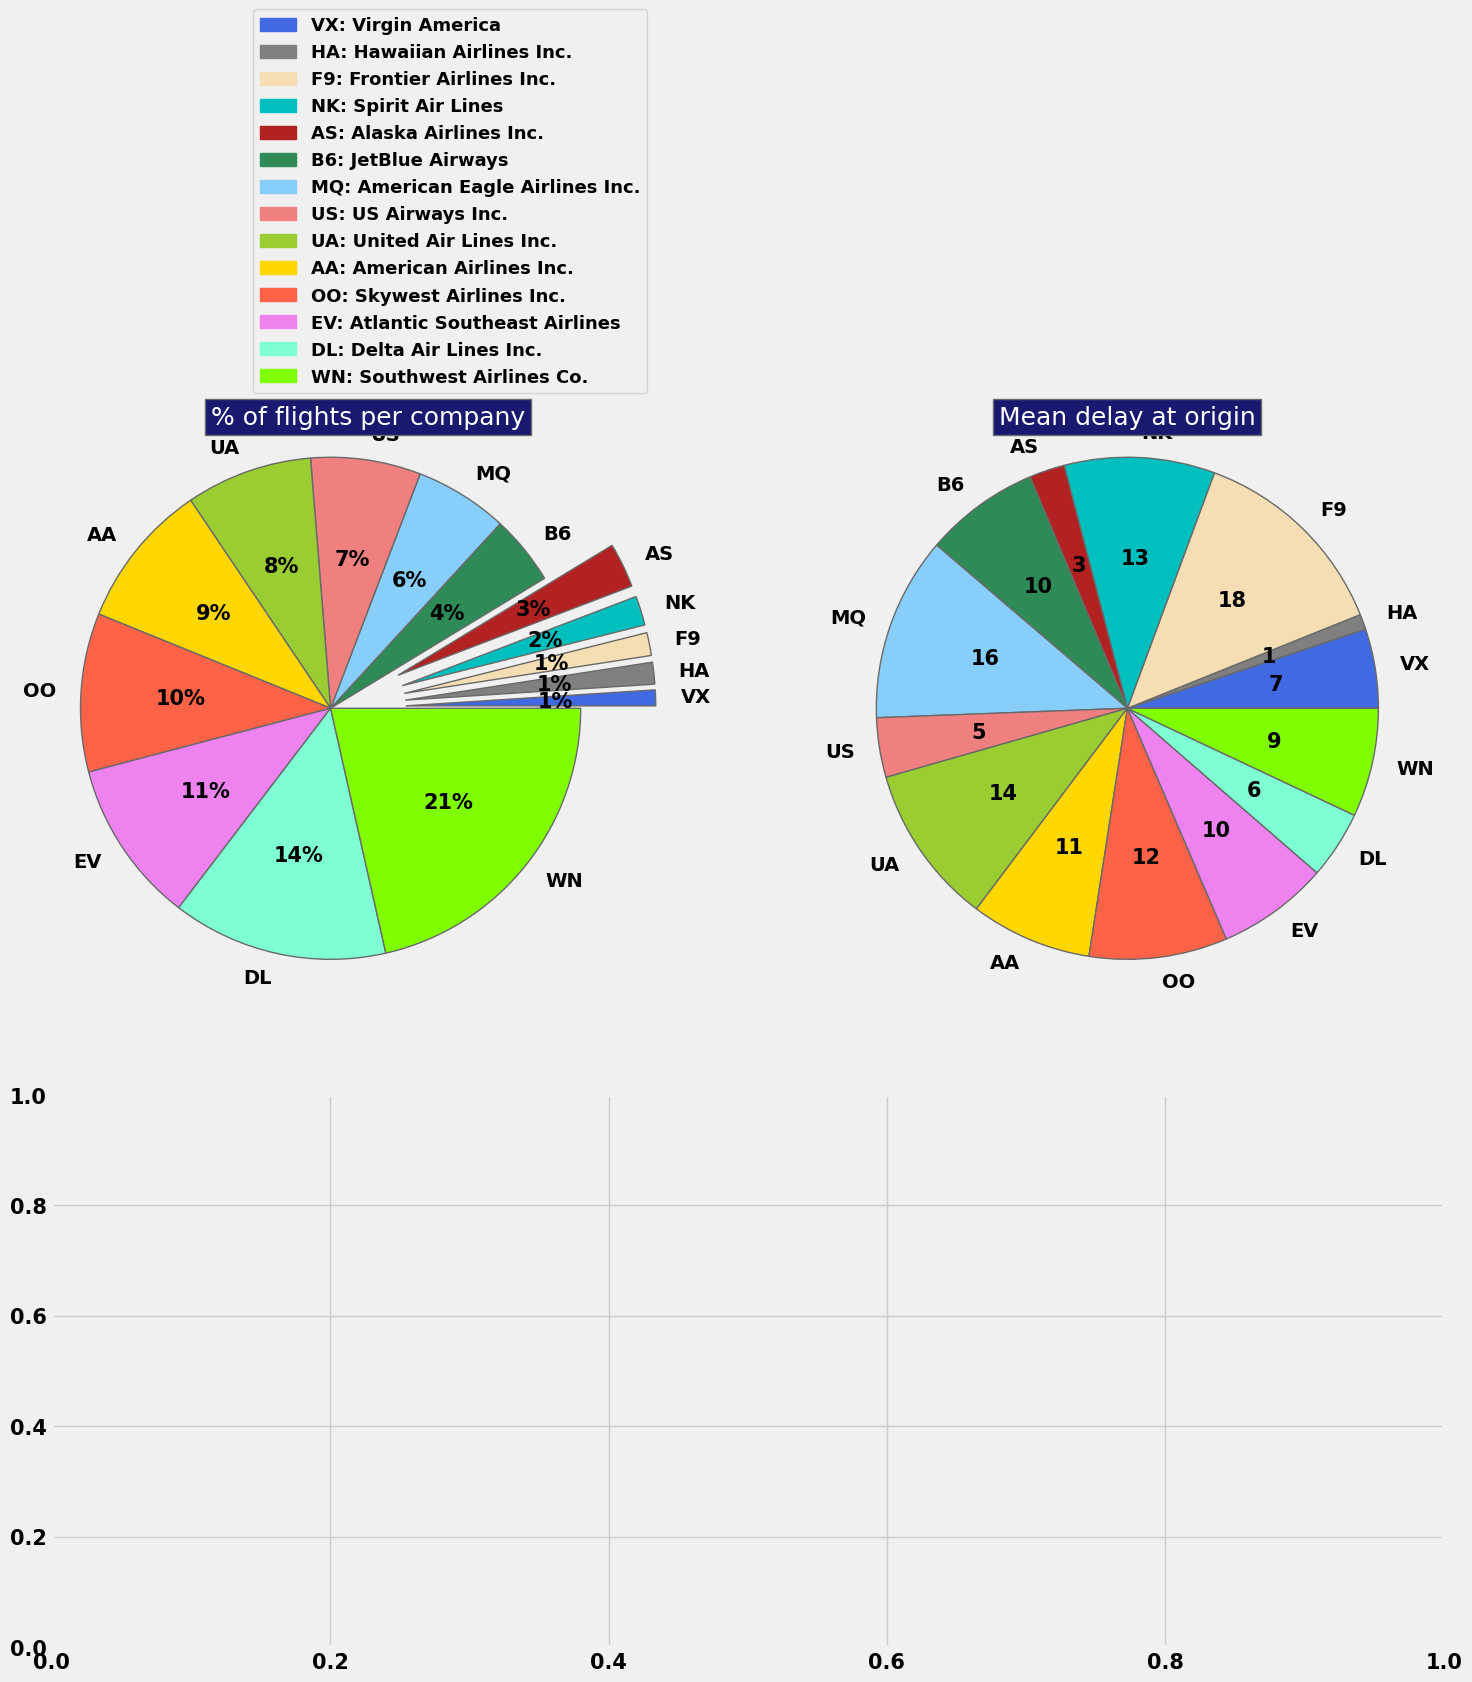

In [173]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE__CODE', 'DEPARTURE_DELAY']]
df2['AIRLINE__CODE'] = df2['AIRLINE__CODE'].replace(abbr_companies)
df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].round().astype(int)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE__CODE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

In [168]:

#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE__CODE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<Figure size 1000x700 with 0 Axes>

In [ ]:
#___________________________________________
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), normed=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000
x_val = [s[1] for s in points]
y_val = [s[0] for s in points]

gs=GridSpec(2,7)
#_______________________________
# 1/ Plot overview (left panel)
ax1=fig.add_subplot(gs[1,0:2]) 
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
#__________________________________
# Company label: Hawaiian airlines
i= 1
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#__________________________________
# Company label: Hawaiian airlines
i= 12
ax1.annotate(label_company[i], xy=(x_val[i]+1.5, y_val[i]+y_shift[i]),
             xycoords='data', fontsize = 10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)
#____________
# Main Title
ax1.text(.5,1.5,'Characterizing delays \n among companies', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
# Create a Rectangle 
rect = patches.Rectangle((21,0.025), 19, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)
#_______________________________________________
# 2/ Zoom on the bulk of carriers (right panel)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)
#________________
# Company labels
for i in range(len(abbr_companies)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
#____________________________
# Increasing delay direction
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('increasing \n  delays', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')    
#________________________________
# Connection between the 2 plots
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
#--------------------------------
plt.show()

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

In [ ]:
print("Nb of airports: {}".format(len(df['ORIGIN_AIRPORT'].unique())))

In [ ]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

In [ ]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [ ]:
temp = airports.copy()
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

In [ ]:
def make_map(df, carrier, long_min, long_max, lat_min, lat_max):
    fig=plt.figure(figsize=(7,3))
    ax=fig.add_axes([0.,0.,1.,1.])
    m = Basemap(resolution='i',llcrnrlon=long_min, urcrnrlon=long_max,
                  llcrnrlat=lat_min, urcrnrlat=lat_max, lat_0=0, lon_0=0,)
    df2 = df[df['AIRLINE'] == carrier]
    count_trajectories = df2.groupby(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']).size()
    count_trajectories.sort_values(inplace = True)
    
    for (origin, dest), s in count_trajectories.iteritems():
        nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
        m.plot(nylon, nylat, marker='o', markersize = 10, markeredgewidth = 1,
                   color = 'seagreen', markeredgecolor='k')

    for (origin, dest), s in count_trajectories.iteritems():
        nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
        lonlat, lonlon = latitude_airport[dest], longitude_airport[dest]
        if pd.isnull(nylat) or pd.isnull(nylon) or \
                pd.isnull(lonlat) or pd.isnull(lonlon): continue
        if s < 100:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=0.5, color='b',
                             label = '< 100')
        elif s < 200:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='r',
                             label = '100 <.< 200')
        else:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='gold',
                              label = '> 200')    
    #_____________________________________________
    # remove duplicate labels and set their order
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    key_order = ('< 100', '100 <.< 200', '> 200')                
    new_label = OrderedDict()
    for key in key_order:
        if key not in by_label.keys(): continue
        new_label[key] = by_label[key]
    plt.legend(new_label.values(), new_label.keys(), loc = 'best', prop= {'size':8},
               title='flights per month', facecolor = 'palegreen', 
               shadow = True, frameon = True, framealpha = 1)    
    m.drawcoastlines()
    m.fillcontinents()
    ax.set_title('{} flights'.format(abbr_companies[carrier]))


In [ ]:
coord = dict()
coord['AA'] = [-165, -60, 10, 55]
coord['AS'] = [-182, -63, 10, 75]
coord['HA'] = [-180, -65, 10, 52]
for carrier in ['AA', 'AS', 'HA']: 
    make_map(df, carrier, *coord[carrier])

In [ ]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

In [ ]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()


In [ ]:
#_________________________________________________________________
# We select the company and create a subset of the main dataframe
carrier = 'AA'
df1 = df[df['AIRLINE']==carrier][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
#___________________________________________________________
# I collect the routes and list the delays for each of them
trajet = dict()
for ind, col in df1.iterrows():
    if pd.isnull(col['DEPARTURE_DELAY']): continue
    route = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
    if route in trajet.keys():
        trajet[route].append(col['DEPARTURE_DELAY'])
    else:
        trajet[route] = [col['DEPARTURE_DELAY']]
#____________________________________________________________________        
# I transpose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()

In [ ]:
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_retards in liste_trajet:
    #_____________________________________________
    # I set the labels as the airport from origin
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # I put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in liste_retards]
    #________________________________________
    # I compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Mean route delays for "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Mean delay at origin (minutes)', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# I define the x,y range and positions of the ticks
imin, imax = 145, 230
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)
#_____________________________
# and set the tick parameters  
ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()

In [ ]:
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])           

In [ ]:
carrier = 'WN'
id_airport = 4
liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
df2 = df[(df['AIRLINE'] == carrier) & (df['ARRIVAL_DELAY'] > 0)
         & (df['ORIGIN_AIRPORT'] == liste_origin_airport[id_airport])]
df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)

In [ ]:
#_______________________________
def func2(x, a, b, c):
    return a * x**2 +  b*x + c
#_______________________________
df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
fct = lambda x:x.hour*3600+x.minute*60+x.second
x_val = np.array([fct(s) for s in test2.index]) 
y_val = test2['mean']
popt, pcov = curve_fit(func2, x_val, y_val, p0 = [1, 2, 3])
test2['fit'] = pd.Series(func2(x_val, *popt), index = test2.index)

In [ ]:
fig1 = Figure_style(8, 4, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot_date(df2['heure_depart'], df2['DEPARTURE_DELAY'],
                    markeredge=False, label='initial data points')
fig1.cust_plot(test2.index, test2['mean'], linestyle='--', linewidth=2, label='mean')
fig1.cust_plot(test2.index, test2['fit'], color='r', linestyle='-', linewidth=3, label='fit')
fig1.style() ; fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure time', fontsize = 14)
fig1.set_ylim(-15, 210)


In [ ]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
df = df_train

In [ ]:
carrier = 'AA'
check_airports = df[(df['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]

In [ ]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
    #_______________________________________
    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    #__________________________________
    # Conversion: date + heure -> heure
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    #___________________________________________________________________
    # regroupement des vols par heure de départ et calcul de la moyenne
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    #___________________________________
    # conversion de l'heure en secondes
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['heure_depart_min'] = test2['heure_depart'].apply(fct)
    return test2

In [ ]:
def linear_regression(test2):
    test = test2[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
    X = np.array(test['heure_depart_min'])
    Y = np.array(test['mean'])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    result = regr.predict(X)
    return X, Y, result

In [ ]:
id_airport = 'PHL'
df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
df2['heure_depart'] = df2['heure_depart'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
#___________________
# first case
test2 = get_flight_delays(df, carrier, id_airport, False)
X1, Y1, result2 = linear_regression(test2)
#___________________
# second case
test3 = get_flight_delays(df, carrier, id_airport, True)
X2, Y2, result3 = linear_regression(test3)

In [ ]:
fig1 = Figure_style(8, 4, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_scatter(df2['heure_depart'], df2['DEPARTURE_DELAY'], markeredge = True)
fig1.cust_plot(X1, Y1, color = 'b', linestyle = ':', linewidth = 2, marker = ('b','s', 10))
fig1.cust_plot(X2, Y2, color = 'g', linestyle = ':', linewidth = 2, marker = ('g','X', 12))
fig1.cust_plot(X1, result2, color = 'b', linewidth = 3)
fig1.cust_plot(X2, result3, color = 'g', linewidth = 3)
fig1.style()
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure time', fontsize = 14)
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

In [ ]:
class fit_polynome:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test = \
                train_test_split(self.X, self.Y, test_size=0.3)
    
    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    
    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
    
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)
The fit_polynome class allows you to perform all o

In [ ]:
fig = plt.figure(1, figsize=(10,4))

ax = ['_' for _ in range(4)]
ax[1]=fig.add_subplot(131) 
ax[2]=fig.add_subplot(132) 
ax[3]=fig.add_subplot(133) 

id_airport = 'BNA'
test2 = get_flight_delays(df, carrier, id_airport, True)

result = ['_' for _ in range(4)]
score = [10000 for _ in range(4)]
found = [False for _ in range(4)]
fit = fit_polynome(test2)

color = '.rgbyc'

inc = 0
while True:
    inc += 1
    fit.split('split')
    for i in range(1,4):
        fit.train(pol_order = i)
        fit.predict(fit.X)
        result[i] = fit.result
        fit.calc_score()
        score[i]  = fit.score

    [ind_min] = [j for j,val in enumerate(score) if min(score) == val]
    print("modèle nº{:<2}, min. pour n = {}, score = {:.1f}".format(inc, ind_min,score[ind_min]))
    
    if not found[ind_min]:            
        for i in range(1,4):
            ax[ind_min].plot(fit.X, result[i], color[i], linewidth = 4 if i == ind_min else 1)
        ax[ind_min].scatter(fit.X, fit.Y)                
        ax[ind_min].text(0.05, 0.95, 'MSE = {:.1f}, {:.1f}, {:.1f}'.format(*score[1:4]),
                         style='italic', transform=ax[ind_min].transAxes, fontsize = 8,
                         bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})                
        found[ind_min] = True

    shift = 0.5
    plt.text(-1+shift, 1.05, "polynomial order:", color = 'k',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0+shift, 1.05, "n = 1", color = 'r', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.4+shift, 1.05, "n = 2", color = 'g', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.8+shift, 1.05, "n = 3", color = 'b',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
   
    if inc == 40 or all(found[1:4]): break


In [ ]:
class fit_polynome_cv:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

    def train(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.result = cross_val_predict(self.regr, self.X_, self.Y, cv = nb_folds)
    
    def calc_score(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.score = np.mean(cross_val_score(self.regr, self.X_, self.Y,
                                             cv = nb_folds, scoring = 'mean_squared_error'))

In [ ]:
#id_airport = 1129804 
nb_folds = 10
print('Max possible number of folds: {} \n'.format(test2.shape[0]-1))
fit2 = fit_polynome_cv(test2)
for i in range(1, 8):
    fit2.calc_score(i, nb_folds)
    print('n={} -> MSE = {}'.format(i, round(abs(fit2.score),3)))

In [ ]:
fit = fit_polynome(test2)
fit.split('all')
fit.train(pol_order = 2)
fit.predict(fit.X)

In [ ]:
fit2.train(pol_order = 2, nb_folds = nb_folds)

In [ ]:
fig1 = Figure_style(8, 4, 1, 1) ; fig1.pos_update(0, 0)
fig1.cust_scatter(fit2.X, fit2.Y, markeredge = True, label = 'initial data points')
fig1.cust_plot(fit.X,fit2.result,color=u'#1f77b4',linestyle='--',linewidth=2,label='CV output')
fig1.cust_plot(fit.X,fit.result,color=u'#ff7f0e',linewidth = 3,label='final fit')
fig1.style(); fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)') ; fig1.set_xlabel('Departure time')
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);


In [ ]:
score = metrics.mean_squared_error(fit.result, fit2.Y)
score

In [ ]:
test_data = get_flight_delays(df_test, carrier, id_airport, True)
test_data = test_data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
X_test = np.array(test_data['heure_depart_min'])
Y_test = np.array(test_data['mean'])
X_test = X_test.reshape(len(X_test),1)
Y_test = Y_test.reshape(len(Y_test),1)
fit.predict(X_test)

In [ ]:
score = metrics.mean_squared_error(fit.result, Y_test)
score

In [ ]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

In [ ]:
def get_merged_delays(df, carrier):
    liste_airports = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    i = 0
    liste_columns = ['AIRPORT_ID', 'heure_depart_min', 'mean']
    for id_airport in liste_airports:
        test2 = get_flight_delays(df, carrier, id_airport, True)
        test2.loc[:, 'AIRPORT_ID'] = id_airport
        test2 = test2[liste_columns]
        test2.dropna(how = 'any', inplace = True)
        if i == 0:
            merged_df = test2.copy()
        else:
            merged_df = pd.concat([merged_df, test2], ignore_index = True)
        i += 1    
    return merged_df

In [ ]:
carrier = 'AA'
merged_df = get_merged_delays(df, carrier)
merged_df.shape

In [ ]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(merged_df['AIRPORT_ID'])
#__________________________________________________________
# correspondance between the codes and tags of the airports
zipped = zip(integer_encoded, merged_df['AIRPORT_ID'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
label_airports[:5]

In [ ]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
b = np.array(merged_df['heure_depart_min'])
b = b.reshape(len(b),1)
X = np.hstack((onehot_encoded, b))
Y = np.array(merged_df['mean'])
Y = Y.reshape(len(Y), 1)
print(X.shape, Y.shape)

In [ ]:
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions = lm.predict(X)
print("MSE =", metrics.mean_squared_error(predictions, Y))

In [ ]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-predictions[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(predictions) * 100)

In [ ]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.plt.show()

In [ ]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X)
regr.fit(X_, Y)

In [ ]:
result = regr.predict(X_)
print("MSE =", metrics.mean_squared_error(result, Y))

In [ ]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-result[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(result) * 100)

In [ ]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
X_train.shape

In [ ]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
regr.fit(X_, Y_train)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_train)
print("Mean squared error = ", score)

In [ ]:
X_ = poly.fit_transform(X_test)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

In [ ]:
somme = 0
for valeurs in zip(result, Y_test):
    ajout = (float(valeurs[0]) - float(valeurs[1]))**2
    somme += ajout
    if ajout > 10**4:
        print("{:<.1f} {:<.1f} {:<.1f}".format(ajout, float(valeurs[0]), float(valeurs[1])))

In [ ]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.3,normalize=True)
poly = PolynomialFeatures(degree = 2)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)

In [ ]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

In [ ]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)        
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha, score))

In [ ]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

In [ ]:
carrier = 'AA'
merged_df_test = get_merged_delays(df_test, carrier)

In [ ]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

merged_df_test['AIRPORT_ID'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = merged_df_test['AIRPORT_ID'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(merged_df_test['heure_depart_min'])
b = b.reshape(len(b),1)
X_test = np.hstack((matrix, b))
Y_test = np.array(merged_df_test['mean'])
Y_test = Y_test.reshape(len(Y_test), 1)

In [ ]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
'MSE = {:.2f}'.format(score)

In [ ]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

In [ ]:
def create_df(df, carrier):
    df2 = df[df['AIRLINE'] == carrier][['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
                                    'ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
    df2.dropna(how = 'any', inplace = True)
    df2['weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.weekday())
    #____________________
    # delete delays > 1h
    df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
    df2.dropna(how = 'any', inplace = True)
    #_________________
    # formating times
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    df2['heure_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    df2['heure_depart'] = df2['heure_depart'].apply(fct)
    df2['heure_arrivee'] = df2['SCHEDULED_ARRIVAL'].apply(fct)
    df3 = df2.groupby(['heure_depart', 'heure_arrivee', 'ORIGIN_AIRPORT'],
                      as_index = False).mean()
    return df3

In [ ]:
df3 = create_df(df, carrier)    
df3[:5]

In [ ]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['ORIGIN_AIRPORT'])
#_________________________________________________________
zipped = zip(integer_encoded, df3['ORIGIN_AIRPORT'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
#_________________________________________________
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#_________________________________________________
b = np.array(df3[['heure_depart', 'heure_arrivee']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df3['DEPARTURE_DELAY'])
Y = Y.reshape(len(Y), 1)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)
        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)
        
        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))

In [ ]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

In [ ]:
df3 = create_df(df_test, carrier)    
df3[:5]

In [ ]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

df3['ORIGIN_AIRPORT'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = df3['ORIGIN_AIRPORT'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(df3[['heure_depart', 'heure_arrivee']])
X_test = np.hstack((matrix, b))
Y_test = np.array(df3['DEPARTURE_DELAY'])
Y_test = Y_test.reshape(len(Y_test), 1)

In [ ]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print('MSE = {}'.format(round(score, 2)))

In [ ]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

In [ ]:
icount = 0
for i, val in enumerate(Y_test):
    if abs(val-predictions[i]) > 15: icount += 1
print("ecarts > 15 minutes: {}%".format(round((icount / len(predictions))*100,3)))

In [ ]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.plt.show()